<a href="https://colab.research.google.com/github/Paradorn657/recurrent_nearal/blob/master/model_forecast_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

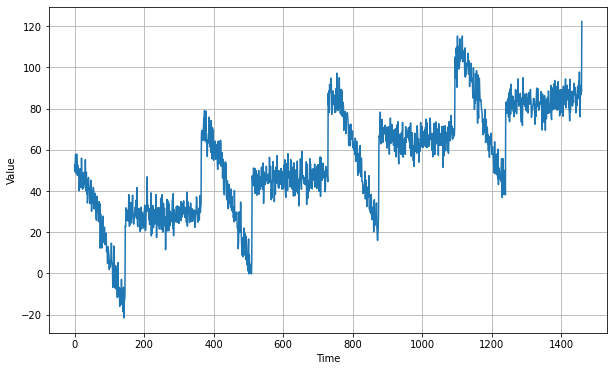

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
def window_dataset(series, window_size, batch_size=32,shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    #เอา ซีรีย์เข้ามาแล้วแบ่งเป็นชุดละ 30 ข้างซ้าย โดยจะทำนาย ข้างขวาคืออนาคต dataset -> x,y
    return dataset

In [0]:
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_series = window_dataset(series_train, window_size)
# train_series จะออกมาเป็นกลุ่ม กลุ่มละ 30  และจะมีลาเบลแต่ละ windowsize shape -> series-windowsize
valid_series = window_dataset(series_valid, window_size)


In [6]:
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
model.compile(loss=keras.losses.Huber(),
              optimizer=keras.optimizers.Adam(),
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_series, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])


Epoch 1/500
31/31 [==============================] - 0s 14ms/step - loss: 68.9528 - mae: 69.4534 - val_loss: 89.7681 - val_mae: 90.2272
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 30.1810 - mae: 31.0065 - val_loss: 18.4194 - val_mae: 18.8544
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 10.5619 - mae: 11.1414 - val_loss: 9.3914 - val_mae: 9.7749
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 9.9226 - mae: 10.5072 - val_loss: 9.5194 - val_mae: 9.9369
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 9.9300 - mae: 10.4851 - val_loss: 9.2116 - val_mae: 9.7477
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 10.0025 - mae: 10.4184 - val_loss: 9.4356 - val_mae: 9.8921
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 9.9741 - mae: 10.4223 - val_loss: 9.0913 - val_mae: 9.6302
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - 

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # แบ่งข้อมูลเป็น ชุดชุดละ window_size แล้ว forecast ค่าถัดไป
    forecast = model.predict(ds)
    return forecast

In [0]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]
# lin_forecast = model_forecast(model, series[970:-1], window_size)[:, 0]

In [9]:
lin_forecast.shape

(461,)

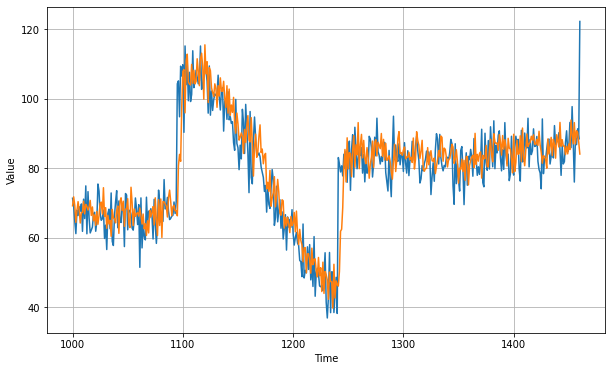

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.56842